# Muli-Doc Analyser with LLMs

Today we test out how LLMs can handle analysing and summarising multiple documents, in which understanding of a document is dependent on the context of its previous documents. 
This is useful in cases where one needs to analyse a sequence of quarterly/annual reports to identify updates and changes over time.

We leverage frameworks such as LangChain and LangGraph to support this task.

Here, I am using Goldman Sachs Private Wealth ISG Outlook from the past three years to identify how its outlook on the market has changed over time. I have scraped its commodities section for simplicity purposes.



### Loading Documents
First, I convert my text in txt files into LangChain Documents

In [53]:
from langchain_core.documents import Document

documents = {
    '2023 Outlook': 'data/2023-isg-outlook-commodities.txt',
    '2024 Outlook': 'data/2024-isg-outlook-commodities.txt',
    '2025 Outlook': 'data/2025-isg-outlook-commodities.txt'
}

data = []

for id, doc in documents.items():
    
    with open(doc, encoding="utf-8") as f:
        text = f.read()

    if text:
        document = Document(page_content=text, id=id)
        data.append(document)

data

[Document(id='2023 Outlook', metadata={}, page_content='Commodities were a bright spot for markets last \nyear (see Exhibit 180). The S&P GSCI returned \n23%, topping all other major asset classes for a \nsecond consecutive year. But this impressive gain \nbelied a more nuanced reality, as returns reached \n54% by early June, only to be halved in the \nsecond half of the year. Investors also faced a wide \ndispersion among individual commodities and their \nsource of returns. In contrast to the index’s overall \nstrength, both industrial metals and precious \nmetals suffered losses last year. And while the \nenergy subindex outperformed with a 39% gain, \nthe bulk of this came from positive carry, or the \nadditional return holders of a commodity get when \nthe futures curve is strongly downward sloping, \ncalled “backwardation.” The appreciation in spot \nenergy prices was a much smaller 14%.  \n\n\nThe disjointed nature of these returns reflects \nthe tug-of-war between bullish suppl

### Creating LangGraph
Here we generate a LangGraph chain in which the LLM generates an initial summary on an initial document, followed by subsequent summaries on following documents whilst relying context from the previous summaries generated

In [67]:
from typing import List, TypedDict
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph
from langchain.chat_models import init_chat_model

# Initialising LLM Model
llm = init_chat_model("gpt-4o-mini", model_provider="openai", temperature=0)


class State(TypedDict):
    content: List[str]
    title: List[str]
    index: int
    summary: str




# Initial summary

initial_template = """
You are writing a summary of multiple documents step by step.

To start, You will be given the first document to summarise.

Write a concise summary of the first document, outlining its main points and themes.

Note: Write down the document title before the document summary.

Document title:
{title}

Document:
{context}
"""

initial_prompt = ChatPromptTemplate([("human", initial_template)])
initial_summary_chain = initial_prompt | llm | StrOutputParser()



# Refining the summary with new docs

refine_template = """
 
Read the summary of the previous document to understand the context and content.  

Use this understanding when writing a summary of the new document, 
incorporating relevant details from the previous document to outline new updates.

Write a concise summary of the new document, highlighting the key similarities and differences compared to the previous document summary.

Note: Write down the document title given before document summary.

Summary of previous document:
{existing_answer}

New Document title:
{title}

New Document:
{context}



"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])
refine_summary_chain = refine_prompt | llm | StrOutputParser()




async def initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        {"title": state["title"][0], "context": state["content"][0]},
        config,
    )
    return {"summary": summary, "index": 1}


async def refine_summary(state: State, config: RunnableConfig):
    content = state["content"][state["index"]]
    title = state["title"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content, "title":title},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


def should_refine(state: State):
    if state["index"] >= len(state["content"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("initial_summary", initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "initial_summary")
graph.add_conditional_edges("initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

### Invoking Graph
Execute the sequence and generate the summaries sequentially.

In [55]:
async for step in app.astream(
    {
    "content": [doc.page_content for doc in data],
    "title" : [doc.id for doc in data]
    },
    stream_mode="values",
):
    if summary := step.get("summary"):
        print("\n===============================================================\n\n")
        print(summary)
        print("\n===============================================================\n\n")




**Document title: 2023 Outlook**

**Document Summary:**
The 2023 Outlook discusses the performance and future expectations for commodities, particularly focusing on oil and gold. In 2022, commodities, led by the S&P GSCI's 23% return, outperformed other asset classes, although this was marked by significant volatility and disparities among individual commodities. Energy prices surged due to geopolitical tensions, particularly from the Russia-Ukraine conflict, but have since retreated due to various bearish factors, including a release from the US Strategic Petroleum Reserve and declining Chinese demand. 

The document highlights the precarious balance between supply-side pressures and demand concerns, particularly in light of low global inventories and potential geopolitical disruptions. It anticipates oil prices to fluctuate between $70 and $100 per barrel, influenced by US production dynamics and global economic conditions.

In contrast, gold's reputation as an inflation hedge has

The results shows the summaries for each document, highlighting the key updates on each year's outlook relative to previous years.

It seems like three main themes are mentioned consistently: 

- General Market Commentary
- Oil
- Gold

Let's refine our documents by splitting them via these common themes to generate a better summary.

## Further Enhancement: Further Splitting of Texts via k-means
Now we use a basic k-means algorithm cluster similar themes together within our documents. 

To simplify the text splitting task, I've manually separated paragraphs in my txt files on the basis that each paragraph would be discussing one particular theme. 

There was an initial idea of performing text splitters by sentences. However, this may overdilute the essence of each sentences formed and remove the contexts from them.


In [56]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pandas as pd

documents = {
    '2023 Outlook': 'data/2023-isg-outlook-commodities.txt',
    '2024 Outlook': 'data/2024-isg-outlook-commodities.txt',
    '2025 Outlook': 'data/2025-isg-outlook-commodities.txt'
}

data = []

for title, doc in documents.items():
    
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0, separators=["\n\n"])
    with open(doc, encoding="utf-8") as f:
        text = f.read()

    splitted_texts = text_splitter.split_text(text)
    for text in splitted_texts:
        data.append({'title':title, 'text':text})


df = pd.DataFrame(data)
df

,title,text
0,2023 Outlook,Commodities were a bright spot for markets las...
1,2023 Outlook,\n\n\nThe disjointed nature of these returns r...
2,2023 Outlook,"\n\n\nAgainst these risks, we note that global..."
3,2023 Outlook,"\n\n\nOil: High Risks, Low Inventories\nOil pr..."
4,2023 Outlook,\n\n\nPrices have since fallen back below pre-...
5,2023 Outlook,"\n\n\nAlthough oil prices have receded, the bu..."
6,2023 Outlook,"\n\n\nAs a result, close to 2 million b/d of R..."
7,2023 Outlook,"\n\n\nTo be sure, the demand for oil faces an ..."
8,2023 Outlook,\n\n\nMeeting this demand will require continu...
9,2023 Outlook,"\n\n\nGiven these moving pieces, we expect WTI..."


### Embeddings
Now we take each text and use openAI's embedding model to embed the message as a vector

In [57]:
from langchain_openai import OpenAIEmbeddings
import os

embeddings = OpenAIEmbeddings(
    model='text-embedding-ada-002',
    api_key=os.getenv('OPENAI_API_KEY')
)

df['embeddings'] = embeddings.embed_documents(df['text'])
df.head(10)

,title,text,embeddings
0,2023 Outlook,Commodities were a bright spot for markets las...,"[-0.002067600842565298, -0.006428479682654142,..."
1,2023 Outlook,\n\n\nThe disjointed nature of these returns r...,"[-0.0205227117985487, -0.03883244842290878, 0...."
2,2023 Outlook,"\n\n\nAgainst these risks, we note that global...","[0.007281305734068155, -0.025253470987081528, ..."
3,2023 Outlook,"\n\n\nOil: High Risks, Low Inventories\nOil pr...","[-0.00777705293148756, -0.03295622393488884, 0..."
4,2023 Outlook,\n\n\nPrices have since fallen back below pre-...,"[-0.014801394194364548, -0.03576892241835594, ..."
5,2023 Outlook,"\n\n\nAlthough oil prices have receded, the bu...","[0.0022193770855665207, -0.04157271981239319, ..."
6,2023 Outlook,"\n\n\nAs a result, close to 2 million b/d of R...","[0.0035941347014158964, -0.031284626573324203,..."
7,2023 Outlook,"\n\n\nTo be sure, the demand for oil faces an ...","[-0.000832091027405113, -0.04939598590135574, ..."
8,2023 Outlook,\n\n\nMeeting this demand will require continu...,"[-0.026792149990797043, -0.04934025555849075, ..."
9,2023 Outlook,"\n\n\nGiven these moving pieces, we expect WTI...","[-0.01866779662668705, -0.03667781129479408, 0..."


### Clustering
Here we will use the sillhouette score to find the ideal number of clusters.

Optimal number of clusters: 2


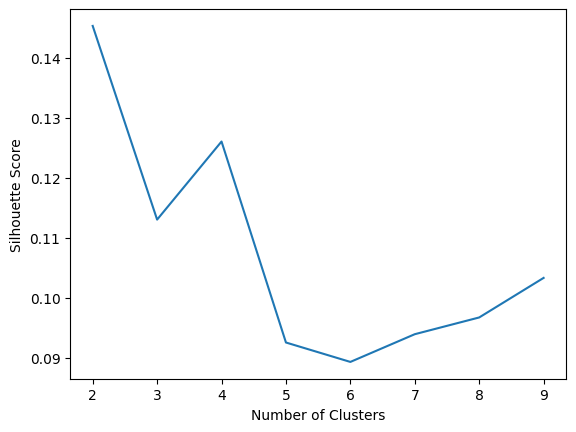

In [58]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

silhouette_scores = []
cluster_range = range(2, 10)  

embedding_matrix = np.array(df['embeddings'].tolist())

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(embedding_matrix)
    labels = kmeans.labels_
    score = silhouette_score(embedding_matrix, labels)
    silhouette_scores.append(score)

optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", optimal_clusters)

plt.plot(cluster_range, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

So it looks like the optimal number of clusters by far is 2. Observing the data again it makes sense, as the paragraphs are likely to be split between the themes of Oil and Gold. 

Now we apply the clustering algorithm towards our data.

In [59]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=optimal_clusters, init="k-means++", random_state=42)
kmeans.fit(embedding_matrix)
labels = kmeans.labels_

df["cluster"] = labels
df.head(10)

,title,text,embeddings,cluster
0,2023 Outlook,Commodities were a bright spot for markets las...,"[-0.002067600842565298, -0.006428479682654142,...",0
1,2023 Outlook,\n\n\nThe disjointed nature of these returns r...,"[-0.0205227117985487, -0.03883244842290878, 0....",1
2,2023 Outlook,"\n\n\nAgainst these risks, we note that global...","[0.007281305734068155, -0.025253470987081528, ...",0
3,2023 Outlook,"\n\n\nOil: High Risks, Low Inventories\nOil pr...","[-0.00777705293148756, -0.03295622393488884, 0...",1
4,2023 Outlook,\n\n\nPrices have since fallen back below pre-...,"[-0.014801394194364548, -0.03576892241835594, ...",1
5,2023 Outlook,"\n\n\nAlthough oil prices have receded, the bu...","[0.0022193770855665207, -0.04157271981239319, ...",1
6,2023 Outlook,"\n\n\nAs a result, close to 2 million b/d of R...","[0.0035941347014158964, -0.031284626573324203,...",1
7,2023 Outlook,"\n\n\nTo be sure, the demand for oil faces an ...","[-0.000832091027405113, -0.04939598590135574, ...",1
8,2023 Outlook,\n\n\nMeeting this demand will require continu...,"[-0.026792149990797043, -0.04934025555849075, ...",1
9,2023 Outlook,"\n\n\nGiven these moving pieces, we expect WTI...","[-0.01866779662668705, -0.03667781129479408, 0...",1


Checking the sizes and chunks of each cluster generated.

In [60]:
df.groupby(['cluster']).size()

cluster
0    26
1    26
dtype: int64

In [61]:
df.groupby(['cluster','title'])['title'].size().reset_index(name='count')

,cluster,title,count
0,0,2023 Outlook,7
1,0,2024 Outlook,10
2,0,2025 Outlook,9
3,1,2023 Outlook,9
4,1,2024 Outlook,8
5,1,2025 Outlook,9


It looks like a steady split of paragraph by cluster and document.

### Loading Documents
Now we group our clustered texts all into one string, then convert our dataframe into LangChain Documents

In [62]:
df['grouped'] = df.groupby(['cluster','title'])['text'].transform(lambda x: "".join(x))
df_grouped = df[['cluster','title','grouped']].drop_duplicates().sort_values(by=['cluster', 'title']).reset_index(drop=True)

pd.set_option('display.max_colwidth', 50)
df_grouped

,cluster,title,grouped
0,0,2023 Outlook,Commodities were a bright spot for markets las...
1,0,2024 Outlook,Last year reminded commodity investors that it...
2,0,2025 Outlook,Commodity markets often change the locks just ...
3,1,2023 Outlook,\n\n\nThe disjointed nature of these returns r...
4,1,2024 Outlook,\n\n\nThe high prices of commodities coming in...
5,1,2025 Outlook,\n\n\nThe relative stability in energy prices ...


In [63]:
from langchain_community.document_loaders import DataFrameLoader

loader = DataFrameLoader(df_grouped, page_content_column='grouped')
new_documents = loader.load()
new_documents

[Document(metadata={'cluster': 0, 'title': '2023 Outlook'}, page_content='Commodities were a bright spot for markets last \nyear (see Exhibit 180). The S&P GSCI returned \n23%, topping all other major asset classes for a \nsecond consecutive year. But this impressive gain \nbelied a more nuanced reality, as returns reached \n54% by early June, only to be halved in the \nsecond half of the year. Investors also faced a wide \ndispersion among individual commodities and their \nsource of returns. In contrast to the index’s overall \nstrength, both industrial metals and precious \nmetals suffered losses last year. And while the \nenergy subindex outperformed with a 39% gain, \nthe bulk of this came from positive carry, or the \nadditional return holders of a commodity get when \nthe futures curve is strongly downward sloping, \ncalled “backwardation.” The appreciation in spot \nenergy prices was a much smaller 14%.  \n\n\nAgainst these risks, we note that global \ninventories have remained

### Creating LangGraph
Same LangGraph creation as earlier

In [64]:
from typing import List, TypedDict
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph
from langchain.chat_models import init_chat_model


llm = init_chat_model("gpt-4o-mini", model_provider="openai", temperature=0)


class State(TypedDict):
    content: List[str]
    title: List[str]
    index: int
    summary: str




# Initial summary

initial_template = """
You are writing a summary of multiple documents step by step.
To start, You will be given the first document to summarise.

Write a concise summary of the first document, outlining the main points.

Note: Write down the document title given before document summary.

Document title:
{title}

Document:
{context}
"""

initial_prompt = ChatPromptTemplate([("human", initial_template)])
initial_summary_chain = initial_prompt | llm | StrOutputParser()



# Refining the summary with new docs

refine_template = """
 
Read the summary of the previous document to understand the context and content.  

Use this understanding when writing a summary of the next document, 
incorporating relevant details from the previous document to outline new updates.

Write a concise summary of the next document, highlighting the key similarities and differences compared to the previous document summary

Note: Write down the document title given before document summary.

Summary of previous document:
{existing_answer}

New Document title:
{title}

New Document:
{context}
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])
refine_summary_chain = refine_prompt | llm | StrOutputParser()




async def initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        {"title": state["title"][0], "context": state["content"][0]},
        config,
    )
    return {"summary": summary, "index": 1}


async def refine_summary(state: State, config: RunnableConfig):
    content = state["content"][state["index"]]
    title = state["title"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content, "title":title},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


def should_refine(state: State):
    if state["index"] >= len(state["content"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("initial_summary", initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "initial_summary")
graph.add_conditional_edges("initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

### Sampling
Lets first evalutate the first cluster to see if everything makes sense.

In [65]:
print(f"\n\nSummary of Theme 0")
cluster_docs = [doc for doc in new_documents if doc.metadata.get('cluster') == 0]

async for step in app.astream(
    {
    "content": [doc.page_content for doc in cluster_docs],
    "title" : [doc.metadata.get("title") for doc in cluster_docs]
    },
    stream_mode="values",
):
    if summary := step.get("summary"):
        print("\n===============================================================\n\n")
        print(summary)
        print("\n===============================================================\n\n")



Summary of Theme 0



**Document title: 2023 Outlook**

**Document Summary:**
The 2023 Outlook highlights the performance of commodities in the previous year, noting that the S&P GSCI achieved a 23% return, outperforming other asset classes for the second year in a row. However, this overall gain masked significant volatility, with returns peaking at 54% by June before halving in the latter half of the year. Individual commodities showed varied performance, with industrial and precious metals experiencing losses, while the energy subindex gained 39%, primarily due to positive carry rather than spot price appreciation.

Despite low global inventories and weak Chinese demand, the document suggests that supply disruptions could impact prices, particularly for industrial metals and oil. The outlook for gold is cautious, as it failed to act as a reliable hedge against inflation in 2022, with its performance negatively affected by rising interest rates and a strong US dollar. The authors m

### Invoking Graph
Looks sufficient now. Let's run it for each cluster and print the results.

In [66]:
for i in range(0,2):
    print("\n===============================================================")
    print(f"Theme {i} \n\n")
    
    cluster_docs = [doc for doc in new_documents if doc.metadata.get('cluster') == i]

    async for step in app.astream(
        {
        "content": [doc.page_content for doc in cluster_docs],
        "title" : [doc.metadata.get("title") for doc in cluster_docs]
        },
        stream_mode="values",
    ):
        if summary := step.get("summary"):
            print(summary)

    print("\n===============================================================\n\n")


Theme 0 


**Document title: 2023 Outlook**

**Document Summary:**
The 2023 Outlook highlights the performance of commodities in the previous year, noting that the S&P GSCI achieved a 23% return, outperforming other asset classes for the second consecutive year. However, this overall strength masked significant volatility, with returns peaking at 54% by June before halving in the latter half of the year. Individual commodities showed varied performance; while the energy subindex gained 39%, industrial and precious metals faced losses. Low global inventories, despite weak Chinese demand, indicate potential price sensitivity to supply disruptions, particularly in politically unstable regions.

The document expresses skepticism about gold's effectiveness as a hedge against inflation and political risk, citing its poor performance in 2022 despite high inflation. Factors such as rising interest rates and a strong US dollar negatively impacted gold prices. The outlook for gold remains neutr

The summaries look much more structured now that they are split between two themes.

The Gold summary has a better concise summary on factors related to Gold such as Central Bank decisions and inflation rates.

On the other hand, the Oil summary is centered around factors such as prices, supply and demand.